<h1 style="text-align: center;" >Flight Delay Estimator</h1>                                          

<p align="center">
<img width="650" src="https://media0.giphy.com/media/1jZvozc11kldsutng6/200w.webp?cid=ecf05e47ij8zyhsvjlyxaqddpb32xzofzqi4ssr3p4mwupdi&rid=200w.webp&ct=g" alt="Assignment 2" title="" />
    
</p>
    

# Table of Content: <a class="car" id="table-of-content"></a>
* [1. Problem Background and Motivation](#problem-background)<br>
* [2. Libraries ](#import-packages)<br>
 * [2.1 User Defined Functions](#udf)<br>    
* [3. Data Preparation](#data-prep)<br>
* [4. Machine Learning Model Implementation](#ml-model)<br>
* [5. Deployment of Model](#model-deployment)<br><br>

[Conclusion](#Conclusion)

# 1. Problem Background and Motivation <a class="car" id="problem-background"></a>

### Flight Status predictor for abc airlines

>**What is the problem in Question?**<br>
>  Using historical data, we will determine whether the flight is likely to be delayed. <br><br>

>**Who will be our stakeholders?**<br>
> * Airline Customers: Airline can issue warning to customers that flight is likely to be delayed so that they can plan accordingly.<br>
> * Airlines: To decrease the amount of flights that are delayed, airlines can alter the flight parameters.<br><br>

>**Why is it important?**<br>
> Flight delays are unavoidable, and they have a significant impact on the airlines' profits and losses. Accurate flight delay estimation is critical for airlines because the results can be used to increase customer satisfaction and airline agency income.




# 2. Libraries Used <a class="car" id="import-packages"></a>
* [Go to Top](#table-of-content)

In [57]:
######################################
# Importing various python libraries
#  1. Pandas is a data analysis and manipulation library. We are using it to read the datasets
#  2. sklearn is machine learning library of python. we need it for running the prediction model.
#  3. Multiple visualization libraries are given below
######################################
import pandas as pd
import numpy as np

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score,roc_curve,plot_roc_curve

pd.set_option('display.max_columns', None)

pd.options.display.float_format = '{:,.2f}'.format

## 2.1 User Defined Functions <a class="car" id="udf"></a>
* [Go to Top](#table-of-content)

In [58]:
#########################
#Additional user defined functions 
#########################
'''
In this Function we are using inbuilt libraries to create a datafraem with all relevant performance measures
'''
def class_perf_measures(model,y_test,probab_threshold):
    # Create empty lists to store metric values created within loop
    TP = []
    TN = []
    FP = []
    FN = []
    recall = []
    precision = []
    F1 = []
    Accuracy = []
    AUC_ROC =[]    

    # Start loop
    for i in probab_threshold:

        # Create class assignments given threshold value
        y_test_pred_class = (model.predict_proba(X_test)[:,1] >= i).astype(int)

        # Append lists with metric values
        TP.append(metrics.confusion_matrix(y_test, y_test_pred_class)[1,1])
        TN.append(metrics.confusion_matrix(y_test, y_test_pred_class)[0,0])
        FP.append(metrics.confusion_matrix(y_test, y_test_pred_class)[0,1])
        FN.append(metrics.confusion_matrix(y_test, y_test_pred_class)[1,0])
        recall.append(metrics.recall_score(y_test, y_test_pred_class).round(3))
        precision.append(metrics.precision_score(y_test, y_test_pred_class,zero_division=0).round(3))
        F1.append(metrics.f1_score(y_test, y_test_pred_class).round(2))
        Accuracy.append(metrics.accuracy_score(y_test, y_test_pred_class).round(2))
        AUC_ROC.append(metrics.roc_auc_score(y_test, y_test_pred_class))

    # Create dataframe
    result = pd.DataFrame({"threshold":threshold,
                           "TP":TP,
                           "TN":TN,
                           "FP":FP,
                           "FN":FN,
                           "Precision":precision,
                           "Recall":recall,
                           "f1":F1,
                           "AUC_ROC":AUC_ROC,
                           "Accuracy": Accuracy
                          })

    # Let's look at our dataframe
    return result

def data_stats(df,feature_list):
    '''
    This function we are calculating basic stats for all numerical columns. 
    To indicate outlier presence we are chcking if std/mean is greater than 1.5. Also if skewness of these columns
    are outside +-3 range
    '''
    temp =  df[feature_list].describe().round(2).T
    temp['median'] = df[feature_list].median().round(2)
    temp['outlier_presence'] = np.where((temp['std']/temp['mean']>1.5)| (df[feature_list].skew(axis = 0)>3) |(df[feature_list].skew(axis = 0)<-3),'True','False')
    return temp







# 3. Data Prep <a class="car" id="data-prep"></a>
* [3.1. Data Ingestion](#data-ingest)<br>
* [3.2. Remove Duplicates/Null values](#null-values)<br>
* [3.3. Feature Selection](#numfeature-selection)<br>
 * [3.3.1 Dealing with Outliers](#outlier-detection)<br>
 * [3.3.2 Check correlation](#correlations)<br>

* [3.4. Dealing with Categorical data](#categorical-data)<br>
 * [3.4.1 Reducing categorical data](#red-categorical-data)<br>
* [3.5. Multivariate Analysis](#mul-analysis)<br>
* [3.6. Feature Transformation and Finalization](#feature-transform)<br>
* [3.7. Splitting the data](#data-split)
* [3.8 Data Normalization](#normalization)




<br><br>
* [Go to Top](#table-of-content)

## 3.1 Data Ingestion <a class="car" id="data-ingest"></a>
* [Go to Data Prep](#data-prep)

In [59]:
df = pd.read_csv("FlightDelays_Clean.csv")

df.tail()

# df.dtypes

,status_delayed,sch_dep_time,carrier_delta,carrier_us,carrier_envoy,carrier_continental,carrier_discovery,carrier_other,dest_jfk,dest_ewr,dest_lga,distance,origin_dca,origin_iad,origin_bwi,bad_weather,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
2196,0,21.33,0,0,0,0,1,0,0,0,1,229,0,1,0,0,0,0,0,1,0,0,0
2197,0,21.33,0,0,0,0,1,0,0,0,1,229,0,1,0,0,0,0,0,0,1,0,0
2198,0,21.33,0,0,0,0,1,0,0,0,1,229,0,1,0,0,0,0,0,0,0,1,0
2199,0,21.33,0,0,0,0,1,0,0,0,1,229,0,1,0,0,0,0,0,0,0,0,1
2200,0,21.33,0,0,0,0,1,0,0,0,1,229,0,1,0,0,1,0,0,0,0,0,0


> **Initial Evaluation**<br>

> status delayed is our target.<br>

> Numerical Variables: sch_dep_time, distance

> Categorical variables: Carrier, Dest(destincation), origin, day of week


## 3.2 Remove Duplicates/Null values <a class="car" id="null-values"></a>
* [Go to Data Prep](#data-prep)

In [60]:
######################################
# Removing duplicates
######################################
cnt =df.shape[0]
print("Number of records before removing duplicates: "+str(cnt))

df.drop_duplicates(inplace =True)

print("Number of records after removing duplicates: "+str(df.shape[0]))
print("Duplicate records in the dataset: "+str(cnt - df.shape[0]))

Number of records before removing duplicates: 2201
Number of records after removing duplicates: 882
Duplicate records in the dataset: 1319


**Note**: there are duplicates. 

In [61]:
######################################
# Removing Null values for our model to work
######################################
#This indicated sum of null values from all columns
# df.isnull().sum()

>**Decision:**
> * No Null values


## 3.3 Numerical Feature Selection <a class="car" id="numfeature-selection"></a>
* [Go to Data Prep](#data-prep)

In [62]:
######################################
# numeric features
######################################

numerical_features = ['sch_dep_time', 'distance']
stats = data_stats(df,numerical_features)
display(stats)


,count,mean,std,min,25%,50%,75%,max,median,outlier_presence
sch_dep_time,882.00,14.01,4.35,6.00,10.50,14.92,17.25,21.50,14.92,False
distance,882.00,211.76,13.52,169.00,213.00,214.00,214.00,229.00,214.00,False


> **Numerical Feature Stats**<br>

> Outlier Presence is calculated from ratio of standard deviation to mean and skewness in the data.<br>

> **Outcome:**<br>
> No Outlier detected. 








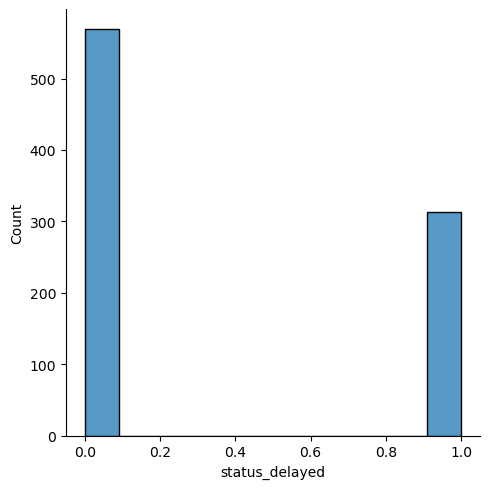

In [63]:
######################################
# Plotting a histogram of our target variable MSRP
######################################

sns.displot(df['status_delayed'])

plt.show()

> **Observation:**<br>
> Since there are only 2 classes for our target, this makes sense.


### 3.3.1 Dealing with Outliers <a class="car" id="outlier-detection"></a>
* [Go to Data Prep](#data-prep)

> **Action Items**<br>
> Not Required

## 3.4 Categorical data <a class="car" id="categorical-data"></a>
* [Go to Data Prep](#data-prep)

> **categorical variables in use:**<br>
Data is already cleaned and we have isolated the required categorical variables<br><br>




## 3.5 Multivariate Analysis <a class="car" id="mul-analysis"></a>
* [Go to Data Prep](#data-prep)

### Multivariate Analysis outcome:<br><Br>

> Not Required





## 3.5 Feature Transformation <a class="car" id="feature-transform"></a><br>

> **Objective:** <br>
> Not Required


* [Go to Data Prep](#data-prep)

## 3.6 Splitting Data <a class="car" id="data-split"></a><br>
> **Creating a test/train split**<br>
* [Go to Data Prep](#data-prep)

In [64]:
predictors =['sch_dep_time', 'carrier_delta', 'carrier_us',
       'carrier_envoy', 'carrier_continental', 'carrier_discovery',
       'carrier_other', 'dest_jfk', 'dest_ewr', 'dest_lga', 'distance',
       'origin_dca', 'origin_iad', 'origin_bwi', 'bad_weather', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

target = ['status_delayed']

X = df[predictors]
y = df[target]

# Split data
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.4,random_state=2)

## 3.7 Data Normalization <a class="car" id="normalization"></a><br>
> **The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information**<br>
> We want to use the summary stats(std dev. and mean) from training data to normalize both training and testing data. 
* [Go to Data Prep](#data-prep)

In [65]:
#We are going to use the Z score to normalize data
means = X_train.mean()
std = X_train.std()

X_train = (X_train - means)/std
X_test = (X_test - means)/std

# 4. Machine Learning Model Implementation<a class="car" id="ml-model"></a>
> * [KNN Model](#first-model)
> * [Logistic Regression Model](#second-model)


-


<br><br>
* [Go to Top](#table-of-content)

> **KNN Model** <a class="car" id="first-model"></a>
<br>
> Objectives:<br>
> * Run a KNN model for different values of K and select a best model based on accuracy.
> * Compare with LR model for different metrics to finalise a model.

In [66]:
K_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
probab_threshold = 0.5
results = []

for i in K_values:
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train.values.ravel())
#     print(knn.predict_proba(X_test))
    y_prediction = (knn.predict_proba(X_test)[:,1]>= probab_threshold ).astype(int)
    
    results.append({'k':i,
                   'Precision': metrics.precision_score(y_test,y_prediction),
                   'Accuracy': metrics.accuracy_score(y_test,y_prediction)})
    
output = pd.DataFrame(results)

output

,k,Precision,Accuracy
0,1,0.20,0.43
1,3,0.32,0.53
2,5,0.39,0.58
3,7,0.51,0.63
4,9,0.47,0.62
5,11,0.48,0.62
6,13,0.47,0.62
7,15,0.49,0.63
8,17,0.45,0.62
9,19,0.45,0.62


**Decision**: Using K = 7 since it is one of the k values with high precision and accuracy. In my Opinion, this model can face serious consequences from false positives  since it is indicating that the flight is delayed even though it is not.

In [67]:
Model1 = KNeighborsClassifier(n_neighbors=7)
Model1.fit(X_train,y_train.values.ravel())
y_pred_knn = Model1.predict(X_test)
# threshold = [0.2,0.4,0.6]
threshold = np.arange(0,1.1,0.1).tolist()
result = class_perf_measures(Model1,y_test,threshold)
result


,threshold,TP,TN,FP,FN,Precision,Recall,f1,AUC_ROC,Accuracy
0,0.00,131,0,222,0,0.37,1.00,0.54,0.50,0.37
1,0.10,126,15,207,5,0.38,0.96,0.54,0.51,0.40
2,0.20,109,59,163,22,0.40,0.83,0.54,0.55,0.48
3,0.30,62,131,91,69,0.41,0.47,0.44,0.53,0.55
4,0.40,62,131,91,69,0.41,0.47,0.44,0.53,0.55
5,0.50,22,201,21,109,0.51,0.17,0.25,0.54,0.63
6,0.60,10,216,6,121,0.62,0.08,0.14,0.52,0.64
7,0.70,10,216,6,121,0.62,0.08,0.14,0.52,0.64
8,0.80,8,222,0,123,1.00,0.06,0.12,0.53,0.65
9,0.90,5,222,0,126,1.00,0.04,0.07,0.52,0.64


> **LR Model** <a class="car" id="second-model"></a>
<br>
> Objectives:<br>
>  1. Run a LR model and evaluate different performance measures. <br>
>  2. compare various metrics to knn and choose a winning model

In [68]:

lr_model = LogisticRegression()
lr_model.fit(X_train,y_train.values.ravel())

y_train_pred_class_LR = lr_model.predict(X_train)
y_test_pred_class_LR = lr_model.predict(X_test)



**Choose a winning model**

In [69]:
print("Accuracy score for KNN model is ",metrics.accuracy_score(y_test,y_pred_knn).round(2))
print("Precision for KNN model is ",metrics.precision_score(y_test,y_pred_knn).round(2))
print("Accuracy score for LR model is ",metrics.accuracy_score(y_test,y_test_pred_class_LR).round(2))


print("Precision for LR model is ",metrics.precision_score(y_test,y_test_pred_class_LR).round(2))

Accuracy score for KNN model is  0.63
Precision for KNN model is  0.51
Accuracy score for LR model is  0.65
Precision for LR model is  0.74


**Note** : to calculate a winning model, I will also be using AUC score.

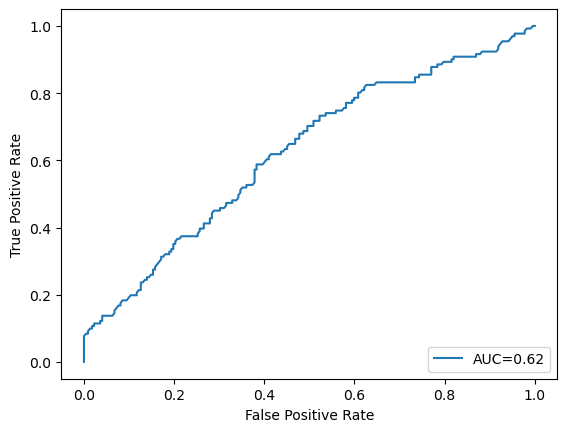

In [70]:
y_pred_Lr = lr_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_Lr)
auc1 = metrics.roc_auc_score(y_test, y_pred_Lr).round(2)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc1))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig('LR_ROC_p2.png')
plt.show()

plt.close()

KNN ROC curve


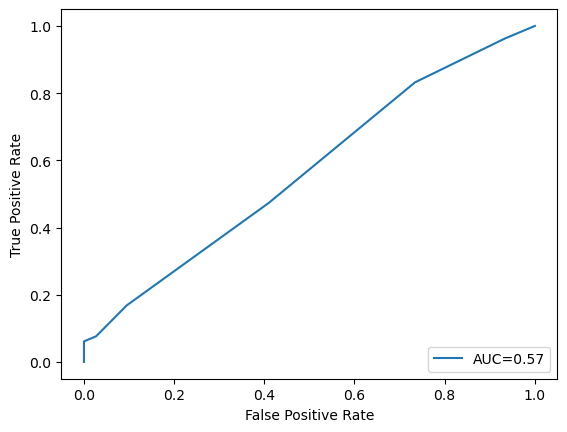

In [71]:
print('KNN ROC curve')
y_pred_proba_KNN = Model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_KNN)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba_KNN).round(2)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc2))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig('KNN_ROC_p2.png')
plt.show()
plt.close()
# plt.savefig('KNN_ROC.png')

> **Final Model Selection**<br><br>
> I believe that our business model can suffer serious consequences due to precision, which means that if our model predicts a large number of false positives, i.e. it indicates that a flight is delayed when it is not, it can cause legal complications for the airlines because its customers will miss their flight when it is on time. It can be observed that the LR model has better precision.<br>

> LR model has high AUC score. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between flight delayed or not.<br><br>
 Therefore, I will be using LR model for further evaluation.<br>
> Some other evaluation measures for classification are:
> * Classification accuracy.
> * Confusion matrix.
> * Precision and recall.
> * F1 score.
> * Sensitivity and specificity.
> * ROC curve and AUC.

In [72]:
class_perf_measures(lr_model,y_test,threshold)

,threshold,TP,TN,FP,FN,Precision,Recall,f1,AUC_ROC,Accuracy
0,0.00,131,0,222,0,0.37,1.00,0.54,0.50,0.37
1,0.10,131,0,222,0,0.37,1.00,0.54,0.50,0.37
2,0.20,119,39,183,12,0.39,0.91,0.55,0.54,0.45
3,0.30,89,114,108,42,0.45,0.68,0.54,0.60,0.58
4,0.40,46,177,45,85,0.51,0.35,0.41,0.57,0.63
5,0.50,14,217,5,117,0.74,0.11,0.19,0.54,0.65
6,0.60,9,222,0,122,1.00,0.07,0.13,0.53,0.65
7,0.70,9,222,0,122,1.00,0.07,0.13,0.53,0.65
8,0.80,9,222,0,122,1.00,0.07,0.13,0.53,0.65
9,0.90,9,222,0,122,1.00,0.07,0.13,0.53,0.65


### Compare Different Thresholds <br>
>  Remember that our objective is to determine if our model that the flight is likely to be delayed or not.<br>

> We will be checking for precision(TP/(TP+FN)) to calculate our ideal threshold.<br>

> 1. **Threshold value 0.2** <br>
>   * **False Positives** :Given the low threshold value, many positive predictions can be made. There will also be a great deal of false positives. We can see from the table that we have 183 false positives, which results in a precision of 0.39. It can cause serious legal consequences to the airlines since it is indicating that the flight is delayed even though it is not. Ther
>   * **False Negatives** : For negative outcome the probabilty has to be atleast 0.8 which is very high. We can observe that the negative prediction are very low and so are the false negatives. If a flight is delayed a customer is entitled to a reimbursement or a rerouting. this also have ramification but they are not as severe to a customer missing the flight cause of the airlines. <br>

>False positives, in my opinion, can have serious consequences for the business model because they cause a customer to miss his flight, which can result in legal consequences for airlines..<br>

> 2. **Threshold value 0.7** <br>
>   * **False Positives** : The false Positive value for this threshold caomes out to be 0 which means our model is predicting 0 delays when it's not. As the threshold value rises, number of postive outcomes reduces since the predicted probability of the oucome should exceed this threshold causing less number of favourable outcomes and thus increase the negative outcomes.
>   * **False Negatives** : The value of the false negative is 122. This means that even if a flight is delayed, our model predicts that it will arrive on time. This has some consequences, such as the airline having to reimburse the passengers or provide an alternate flight, but it is still preferable to a customer missing their flight because the airline said so.
>   * As was previously said, our business model demands that false positives may have negative consequences. This is superior to our previous cutoff point of 0.2. Additionally, the accuracy is 65%, which is okay compared to rest of the threshold values. <br>



> 3. **Threshold value 0.8** <br>
>  * **False Positives** : This threshold value is really high. As a result, our model will typically forecast unfavorable results. As we can see from the table,  FP have 0 values (false positive). showing that there are no records where we indicate flight getting delayed when it is not. Also there are only 9 records where we have probability high enough to give correct positive results.
>  * **False Negatives** : Although this resolves our false positive problem, it also increases recall. we are indicating that 122 records are marked with negative outcome even though the flight was delayed.


**I will be using 0.5 which gives a correct blend of false positives and false negatives(i am giving importance to precision over recall)**

# 5. Deployment of Model <a class="car" id="model-deployment"></a>

* [Go to Top](#table-of-content)

In [73]:
import pickle
pickle_out = open('classifier_flight_ind', mode='wb')
pickle.dump([lr_model,knn,means.to_list(),std.to_list()], pickle_out)

pickle_out.close()

In [74]:
%%writefile flight_delay_indicator_app.py
import streamlit as st
import pickle
import numpy as np

pickle_in = open('classifier_flight_ind', 'rb')
pkl_in = pickle.load(pickle_in)

lr_model = pkl_in[0] 
knn = pkl_in[1]
means = pkl_in[2]
std = pkl_in[3]


@st.cache()


# Define the function which will make the prediction using data
# inputs from users
def prediction(input_list, prediction_probability, model_type ='LR'):
    # Make predictions
    if model_type =='LR':
        prediction = (lr_model.predict_proba([input_list])[::,1]>= prediction_probability ).astype(int)
    elif model_type =='KNN':
        prediction = (knn.predict_proba([input_list])[::,1]>= prediction_probability ).astype(int)
    
    if prediction == 0:
        pred = 'Flight Is On-time'
    else:
        pred = ' Wait! Flight is delayed'
    return pred

def set_carrier(carrier):
    carrier_delta=0
    carrier_us=0
    carrier_envoy=0
    carrier_continental=0
    carrier_discovery=0
    carrier_other=0
    
    if carrier =='delta':
        carrier_delta =1
    elif carrier =='us':
        carrier_us =1
    elif carrier =='envoy':
        carrier_envoy =1
    elif carrier =='continental':
        carrier_continental =1
    elif carrier =='discovery':
        carrier_discovery =1
    else: carrier_other = 1
    
    return carrier_delta,carrier_us,carrier_envoy,carrier_continental,carrier_discovery,carrier_other

def set_origin(origin):
    origin_dca = 0
    origin_iad = 0
    origin_bwi = 0
    
    if origin =='dca':
        origin_dca = 1
    elif origin =='iad':
        origin_iad = 1
    else: origin_bwi = 1
    
    return origin_dca,origin_iad,origin_bwi

def set_dest(dest):
    dest_jfk = 0
    dest_ewr = 0
    dest_lga = 0
    
    if dest =='jfk':
        dest_jfk = 1
    elif dest =='ewr':
        dest_ewr = 1
    else: dest_lga = 1
    
    return dest_jfk,dest_ewr,dest_lga

def select_day_of_week(day_of_week):
    Monday = 0
    Tuesday = 0
    Wednesday = 0
    Thursday = 0
    Friday = 0
    Saturday = 0
    Sunday = 0
    
    if day_of_week =='Monday':
        Monday =1
    elif day_of_week =='Tuesday':
        Tuesday =1
    elif day_of_week =='Wednesday':
        Wednesday =1
    elif day_of_week =='Thursday':
        Thursday =1
    elif day_of_week =='Friday':
        Friday =1
    elif day_of_week =='Saturday':
        Saturday = 1
    elif day_of_week =='Sunday':
        Sunday = 1
        
    return Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
        
    

def main():
    
    # Create input fields
    st.markdown("<h1 style='text-align: center; color: red;'>Flight Status Predictor</h1>", unsafe_allow_html=True)
    
    sch_dep_time = st.number_input("Departure Time(in 24 hour format)",
                                  min_value=0,
                                  max_value=20,
                                  value=2,
                                  step=1,
                                 )
    carrier = st.selectbox("Select Airline Carrier",['delta','us','envoy','continental','discovery','other'])
    carrier_delta,carrier_us,carrier_envoy,carrier_continental,carrier_discovery,carrier_other = set_carrier(carrier)
    
    origin = st.selectbox("Select origin",['dca', 'iad', 'bwi'])
    origin_dca,origin_iad,origin_bwi = set_origin(origin)
    
    dest = st.selectbox("Select Destination",['jfk', 'ewr', 'lga'])
    dest_jfk,dest_ewr,dest_lga = set_dest(dest)
                                              
    
    day_of_week = st.selectbox("Select Day of the week",['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday = select_day_of_week(day_of_week)
    
                                              
    bad_weather = st.number_input("Select if weather is bad or not (0-1)",
                              min_value=0,
                              max_value=1,
                              value=1,
                              step=1
                             )
    
    distance = st.number_input("Distance in Miles",
                          min_value=0,
                              max_value=100000,
                              value=229,
                              step=100
                         )
                                              
    
    model_type = st.sidebar.selectbox("Model type", ['KNN','LR'])
    prediction_probability = [st.sidebar.slider("Probablity Threshold",0.0, 1.0, 0.3, 0.01)]
    
    #scaling data with test stats used for training
    
    
    input_data = [sch_dep_time,carrier_delta,carrier_us,
       carrier_envoy,carrier_continental,carrier_discovery,
       carrier_other,dest_jfk,dest_ewr,dest_lga,distance,
       origin_dca,origin_iad,origin_bwi,bad_weather,Monday,
       Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday]
    
    input_list1 = np.divide(np.subtract(input_data,means),std).tolist()
    
    result = ""
#     with st.sidebar:
#         result = prediction(sch_dep_time,carrier_delta,carrier_us,
#        carrier_envoy,carrier_continental,carrier_discovery,
#        carrier_other,dest_jfk,dest_ewr,dest_lga,distance,
#        origin_dca,origin_iad,origin_bwi,bad_weather,Monday,
#        Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday, prediction_probability, model_type)
#         st.success(result)
        

    
    # When 'Predict' is clicked, make the prediction and store it
    if st.button("Predict"):
        result = prediction(input_list1, prediction_probability, model_type)
        if result =='Flight Is On-time':
            st.balloons()
        st.success(result)
        
    if st.button('Show ROC curve'):
        if model_type =='KNN':
            st.image('KNN_ROC_p2.png',caption='KNN ROC image')
        elif model_type =='LR':
            st.image('LR_ROC_p2.png',caption='LR ROC image')
       
if __name__=='__main__':
    main()

Writing flight_delay_indicator_app.py


In [75]:
!streamlit run flight_delay_indicator_app.py

^C


# Conclusion <a class="car" id="Conclusion"></a>

> The model has low accuracy predicting flight delay. We need some more data to train our model with different parameters so that it can be more accurate.




* [Go to Top](#table-of-content)